In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import numpy as np
import pickle
import re
from pathlib import Path
import pandas as pd
path = Path('/home/lyk/Documents/datasets/europarl')

In [3]:
file_dates=[]
for fname in (path/'txt/en full').glob('*.txt'):
    date = re.search('ep-(.{8}).txt',str(fname))
    if date is not None:
        file_dates.append(date.group(1))

In [4]:
series = pd.to_datetime(pd.Series(file_dates), format='%y-%m-%d')
series.index = series.dt.to_period('y')
series = series.groupby(level=0).size()

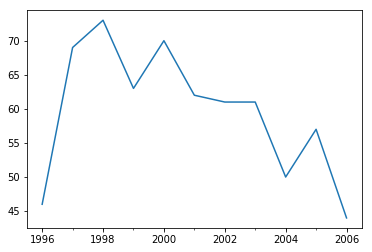

In [5]:
ax = series.plot()
#ax.set_xlim(pd.Timestamp('2002-01-01'),pd.Timestamp('2004-01-01'))

In [6]:
file_list=[]
for fname in (path/'txt/en').glob('*.txt'):
    file_list.append(re.sub(' +',' ',re.sub('\n',' ',(re.sub('<.+>',' ',fname.open('r').read())))))

In [7]:
len(file_list) #number of files

142

In [8]:
tokenizer = spacy.load('en')
tok = [tokenizer(text.lower()) for text in file_list]

In [9]:
docs = [[token.lemma_ for token in t if token.is_stop!=True and token.is_punct!=True and len(token)>2] for t in tok] 
#words = [token.text for token in tok if token.is_punct!=True and len(token)>2]
#words = [token.text for token in tok if token.is_stop!=True and token.is_punct!=True and len(token)>2]

In [11]:
pickle.dump(docs, open(path/'ep1997-1998.pkl','wb'))

In [8]:
docs = pickle.load(open(path/'ep1997-1998.pkl','rb'))

### EDA

In [13]:
words_list=[i for s in docs for i in s]
words_string=' '.join(w for w in words_list)

In [14]:
freq=Counter(words_list)
freq.most_common(10)

[('european', 37575),
 ('commission', 29282),
 ('president', 22842),
 ('report', 21295),
 ('state', 20738),
 ('parliament', 20406),
 ('union', 19433),
 ('member', 19237),
 ('country', 16546),
 ('council', 14912)]

<BarContainer object of 10 artists>

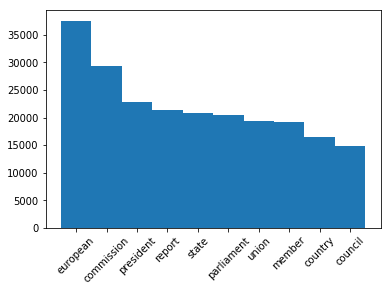

In [15]:
labels, values = zip(*freq.most_common(10))
index = np.arange(len(labels))
plt.xticks(index,labels,rotation=45)
plt.bar(index, values,1)

In [16]:
wordcloud = WordCloud(background_color='white',
                     width=1800,
                     height=1400).generate_from_frequencies(freq)

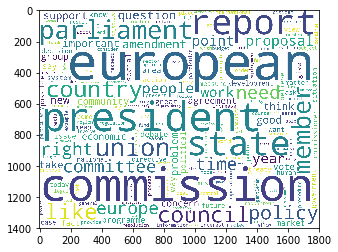

In [17]:
plt.imshow(wordcloud)

### LDA

In [9]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora, models
import logging

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [10]:
bigram=Phrases(docs,min_count=20)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token: #it is a bigram
            docs[idx].append(token)

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
dictionary = corpora.Dictionary(docs)

In [12]:
dictionary.filter_extremes(no_below=5,no_above=0.8)

In [13]:
corpus=[dictionary.doc2bow(text) for text in docs]

In [14]:
len(dictionary),len(corpus)

(13145, 142)

In [15]:
logging.basicConfig(filename='gensim.log',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [16]:
%%time
#load lda model
lda = gensim.models.ldamodel.LdaModel

#set number of topics and words
ldamodel=lda(corpus,num_topics=20, id2word=dictionary, eval_every=1, passes=20, iterations=2200)
topics = ldamodel.show_topics(num_topics=20, num_words=10, formatted=False)

for t in range(len(topics)):
    print(f"Topic {t+1}:")
    print(", ".join(w[0] for w in topics[t][1]))

Topic 1:
petition, madam_president, ombudsman, hong_kong, kong, hong, emission, fuel, noise, albania
Topic 2:
patent, modify, genetically, genetically_modify, food, madam_president, genetic, labelling, gene, medicine
Topic 3:
euro, drug, tourism, central_bank, uclaf, corruption, agency, fraud, ecb, reserve
Topic 4:
madam_president, president_office, military, turkey, refugee, russia, war, kosovo, regime, arm
Topic 5:
racism, terrorism, xenophobia, structural_fund, sme, racism_xenophobia, racist, terrorist, fifth, community_law
Topic 6:
fishery, fishing, fish, forest, renewable, producer, tobacco, quota, stock, fisherman
Topic 7:
fishery, fishing, island, vessel, fish, madam_president, fisherman, urban, fishery_agreement, fleet
Topic 8:
agency, postal, death, reading, conciliation, nuclear, food, madam_president, fuel, beef
Topic 9:
euro, currency, central_bank, single_currency, stability, emu, economic_monetary, cohesion, monetary_policy, farmer
Topic 10:
russia, austrian, turkey, koso

Text(0.5,1,'Topic Model Convergence')

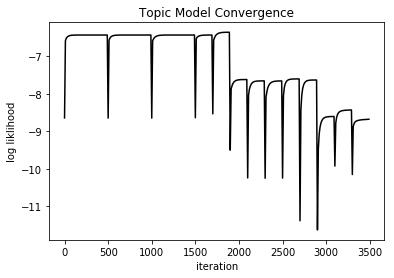

In [28]:
p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,liklihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")